In [1]:
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import rasterio.features 
import shapely.geometry
from rasterio.features import shapes
import rasterio
from scipy.ndimage import binary_closing, binary_fill_holes, binary_dilation, binary_erosion


# Opening file

Opening a Brazilian biomes geojson

<Axes: >

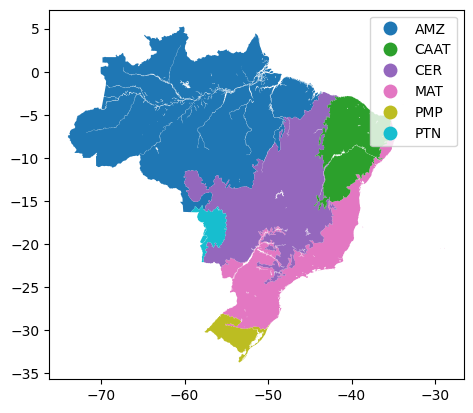

In [32]:
gdf = gpd.read_file('static/biomes.geojson')
gdf.plot(column='COD_BIOMA', legend=True)

## The blanks

In this case, the 'blanks' are the river markings present in the Amazon biome, however, for experimental purposes, let's consider that we need to fill these blank spaces in our geometry.

<Axes: >

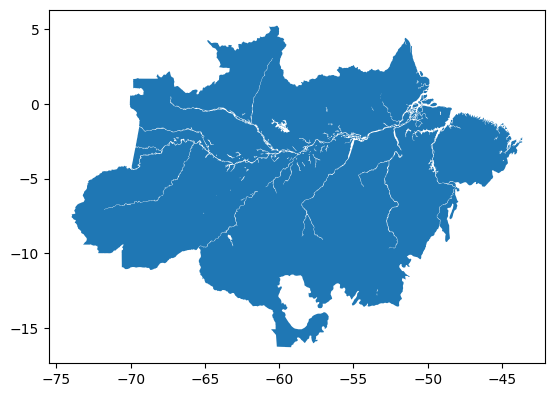

In [33]:
geometry_with_blanks = gdf.loc[gdf['COD_BIOMA'] == 'AMZ', 'geometry']
geometry_with_blanks.plot()

# Buffer

### Buffer Methodology in Geospatial Analysis

The *buffer* method is a widely used spatial analysis tool in geographic information systems (GIS) and geospatial analysis. It involves creating a zone or area of a specified distance around a point, line, or polygon feature. This method is often used to analyze proximity, spatial relationships, and to define regions of influence.

#### 1. What is a Buffer?

A *buffer* is a zone around a spatial feature that extends outward by a fixed distance. This distance can be defined in map units (e.g., meters or kilometers) and is used to determine areas of influence or regions that are affected by or related to a given feature. Buffers can be created around points, lines, or polygons.

#### 2. How is a Buffer Created?

The buffer is created by taking each point on the feature (whether it is a point, line, or polygon) and generating a circle around it with a radius equal to the buffer distance. When applied to line or polygon features, these circles are joined together to form a continuous area around the feature.

#### 3. Types of Buffers

There are several types of buffers commonly used in geospatial analysis:

- **Fixed-distance buffer:** A buffer with a constant radius around the feature. For example, creating a 500-meter buffer around a road to identify areas affected by noise pollution.
- **Variable-distance buffer:** A buffer where the distance varies based on attribute values of the feature. For example, creating a larger buffer around a river depending on its width.
- **Dissolved buffer:** A buffer that merges overlapping buffer zones into a single continuous area.
- **Non-dissolved buffer:** A buffer where overlapping buffer zones remain distinct.

#### 4. Buffer Equation

Mathematically, for a point feature at location $(x, y)$, the buffer zone is the set of points $(x', y')$ that satisfy the following condition:

$$
\sqrt{(x' - x)^2 + (y' - y)^2} \leq d
$$

where:
- $(x', y')$ are the coordinates of a point within the buffer,
- $(x, y)$ is the location of the original point feature,
- $d$ is the buffer distance.

For line and polygon features, the buffer is constructed by generating a buffer for each point on the feature and then joining these buffer zones together.

#### 5. Applications of Buffering in Geospatial Analysis

Buffering is a versatile tool with a wide range of applications in geospatial analysis:

- **Proximity analysis:** Identifying areas within a certain distance of features such as roads, rivers, or buildings. For example, determining which properties are within 1 km of a school.
- **Environmental impact assessments:** Defining buffer zones around sensitive areas such as wetlands or habitats to evaluate potential impacts of development.
- **Service area analysis:** Creating buffer zones around hospitals, fire stations, or other services to analyze coverage and accessibility.
- **Risk and hazard analysis:** Creating buffers around hazardous sites (e.g., chemical plants or fault lines) to assess the risk to nearby populations.

#### 6. Dissolved vs. Non-Dissolved Buffers

- **Dissolved buffer:** When buffers overlap, they are merged into a single continuous area. This is useful when you are interested in the total area influenced by a set of features without concern for individual boundaries.
- **Non-dissolved buffer:** When buffers overlap, they remain separate. This is useful when you want to preserve individual features' buffer zones for further analysis.

#### 7. Limitations of Buffering

While buffering is a powerful tool, it has some limitations:
- **Scale-dependent:** The results of a buffer analysis can vary depending on the spatial resolution of the data and the scale of the map.
- **Assumes uniform influence:** Buffering assumes that the influence of a feature is uniform within the buffer distance, which may not always be realistic (e.g., noise pollution may not decrease uniformly with distance).

#### 8. Examples of Buffering in Practice

- **Urban Planning:** Creating buffer zones around roads or public transportation lines to identify areas that have easy access to transportation services.
- **Environmental Conservation:** Defining buffer areas around lakes and rivers to protect water quality from nearby land use activities.
- **Public Health:** Buffering around sources of pollution to assess the potential impact on nearby populations.

### Summary of Steps

1. Define the feature (point, line, or polygon) and the buffer distance.
2. For each point in the feature, create a circular buffer with the specified radius.
3. If working with lines or polygons, join the circular buffers to create a continuous area.
4. Use the buffer for proximity analysis, impact assessment, or accessibility evaluation.


Explore more in https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoSeries.buffer.html


/tmp/ipykernel_39696/3832655509.py:5: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_buffered['geometry'] = gdf_buffered['geometry'].buffer(distance=.11)


<Axes: >

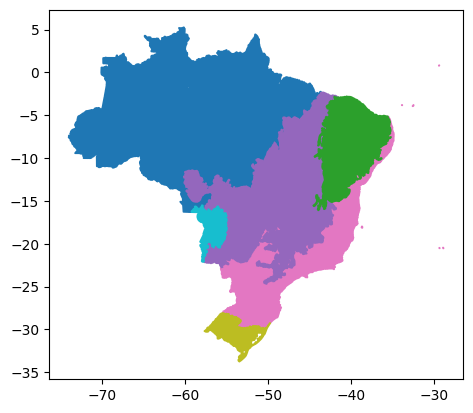

In [41]:
# create a copy from gdf
gdf_buffered = gdf.copy()

# applying buffer, change the distance according to your problem
gdf_buffered['geometry'] = gdf_buffered['geometry'].buffer(distance=.11)
gdf_buffered.plot(column='COD_BIOMA')

### Rasterization in Geospatial Analysis

*Rasterization* is the process of converting vector data (such as points, lines, and polygons) into a raster format, which consists of a grid of cells (pixels), each with a specific value. In geospatial analysis, rasterization is commonly used to convert vector data into a format suitable for raster-based operations, such as spatial analysis, image processing, and modeling.

#### 1. What is Rasterization?

Raster data is represented as a grid of pixels, each associated with a value. Rasterization involves assigning values to these pixels based on the vector features that intersect with them. Each pixel represents a specific geographic area, and the value assigned to the pixel depends on the presence or absence of a vector feature within that area.

- For **points**, the pixel containing the point is assigned a value.
- For **lines**, pixels along the path of the line are assigned a value.
- For **polygons**, all pixels inside the polygon are assigned a value.

Rasterization is useful for converting detailed vector features into a regular grid format that can be used for analysis like terrain modeling, land cover classification, and environmental impact assessments.

#### 2. Binary Morphological Operations

Morphological operations are used in image processing and raster analysis to manipulate the structure of binary images (raster data where each pixel is either 0 or 1). Below are brief explanations of three commonly used morphological operations: `binary_dilation`, `binary_fill_holes`, and `binary_erosion`.

##### a. `binary_dilation`

*Binary dilation* expands the boundaries of objects in a binary image. It increases the size of regions of value 1 (foreground), filling in small holes and connecting disjointed elements.

The operation works by placing a structuring element (typically a square or circle) over each pixel. If any pixel within the structuring element is part of the foreground (value 1), the pixel at the center of the structuring element is also set to the foreground.

Mathematically, for a set $A$ and structuring element $B$, binary dilation is defined as:

$$
A \oplus B = \{ z : (B)_z \cap A \neq \emptyset \}
$$

where $(B)_z$ is the structuring element shifted by $z$.

##### b. `binary_fill_holes`

*Binary fill holes* is used to fill in isolated regions of background pixels (value 0) that are surrounded entirely by foreground pixels (value 1). This operation is useful for cleaning up binary images where regions inside objects might incorrectly appear as background.

It effectively fills any "holes" in the binary image that are completely enclosed by the foreground.

##### c. `binary_erosion`

*Binary erosion* shrinks the boundaries of objects in a binary image, reducing the size of regions of value 1. It removes pixels on the edges of regions, effectively "eroding" the shape of the foreground objects.

The operation is the inverse of dilation, working by placing a structuring element over each pixel. If all pixels within the structuring element are part of the foreground, the center pixel remains foreground; otherwise, it is set to background (value 0).

Mathematically, for a set $A$ and structuring element $B$, binary erosion is defined as:

$$
A \ominus B = \{ z : (B)_z \subseteq A \}
$$

#### 3. Applications

- **Rasterization** is used for terrain modeling, land use analysis, and converting vector data into a format suitable for machine learning models.
- **Binary dilation** is used to expand or connect regions, often applied in preprocessing for object detection.
- **Binary fill holes** is used in medical imaging and remote sensing to ensure that enclosed regions are properly filled.
- **Binary erosion** is used to reduce noise and remove small objects from binary images, useful in clean-up operations for image segmentation.

### Summary of Operations

1. **Rasterization:** Converts vector data into raster format for spatial analysis.
2. **Binary dilation:** Expands the boundaries of objects, filling small gaps.
3. **Binary fill holes:** Fills enclosed background regions within objects.
4. **Binary erosion:** Shrinks object boundaries, removing edge pixels to clean up the image.

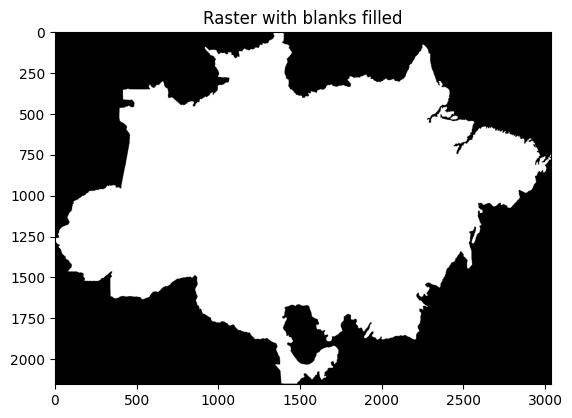

                                            geometry  raster_value
0  POLYGON ((-49.58060 0.08050, -49.50060 0.08050...           1.0
1  POLYGON ((-60.20060 5.23050, -60.09060 5.23050...           1.0


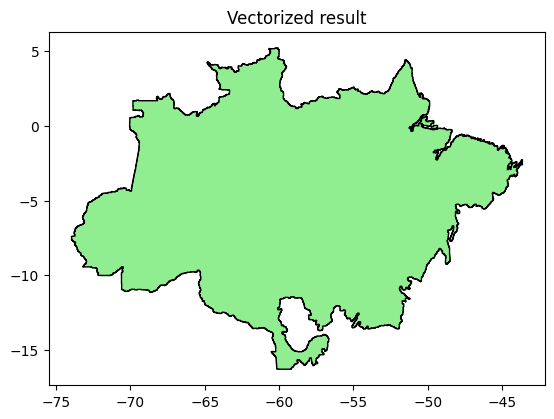

In [48]:

gdf = gdf.loc[gdf['COD_BIOMA'] == 'AMZ']

# defining raster parameters
pixel_size = 0.01  # resolutions
x_min, y_min, x_max, y_max = gdf.total_bounds # bounds

# setting grid
width = int((x_max - x_min) / pixel_size)
height = int((y_max - y_min) / pixel_size)

# set raster transformation
transform = rasterio.transform.from_origin(x_min, y_max, pixel_size, pixel_size)

# init raster with zero values
out_image = np.zeros((height, width), dtype=np.uint8)

# rasterezing the geometry
for geom in gdf.geometry:
    mask = rasterio.features.geometry_mask([geom],
                                           transform=transform, 
                                           invert=True, 
                                           out_shape=(height, width))
    out_image += np.where(mask, 1, 0).astype(np.uint8)  # make sure that we're working with uint8

# applying dilation to expand the pixels 
dilated_raster = binary_dilation(out_image, structure=np.ones((5, 5))).astype(np.uint8)

# filling the blanks
filled_raster = binary_fill_holes(dilated_raster).astype(np.uint8)

# applying erosion operation to keep original boundaries
final_raster = binary_erosion(filled_raster, structure=np.ones((5, 5))).astype(np.uint8)

# plots
plt.imshow(final_raster, cmap='gray', origin='upper')
plt.title("Raster with blanks filled")
plt.show()


# reverse transform, return the raster to a vectorized results
mask = final_raster > 0  # only true pixels
results = (
    {'properties': {'raster_value': v}, 'geometry': shapely.geometry.shape(s)}
    for s, v in rasterio.features.shapes(final_raster, mask=mask, transform=transform)
)

# create a geodataframe
gdf_filled = gpd.GeoDataFrame.from_features(results)

# set the CRS
gdf_filled.set_crs(epsg=4326, inplace=True)

# saving the results
# shapefile_output = 'biomas_filled.shp'
# gdf_filled.to_file(shapefile_output, driver='ESRI Shapefile')

# plot
gdf_filled.plot(color='lightgreen', edgecolor='black')
plt.title("Vectorized result")
plt.show()